# Lab  3 - Implementing Logistic Regression with Gradient Descent using Theano

## Learning Aims

- Using Theano
- Logistic regression
- Supervised learning
- Automatic differentiation
- Gradient descent
$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\Var}{\mathrm{Var}}$
$\newcommand{\Cov}{\mathrm{Cov}}$
$\newcommand{\SampleAvg}{\frac{1}{N({S})} \sum_{s \in {S}}}$
$\newcommand{\indic}{\mathbb{1}}$
$\newcommand{\avg}{\overline}$
$\newcommand{\est}{\hat}$
$\newcommand{\trueval}[1]{#1^{*}}$
$\newcommand{\Gam}[1]{\mathrm{Gamma}#1}$

## Installing Theano

We shall be using Theano 0.6 in this course:
http://deeplearning.net/software/theano/index.html

### Installation

In Anaconda:

$ pip install Theano

If you are not using Anaconda, additional installation instructions can be found here:

http://deeplearning.net/software/theano/install.html

### Theano at a glance

Theano is a Python library that lets you to define, optimize, and evaluate mathematical expressions, especially ones with multi-dimensional arrays. Some of its advantages over other libraries, such as numpy are:

- Execution speed optimizations: Theano can use g++ or nvcc to compile parts your expression graph into CPU or GPU instructions, which run much faster than pure Python.
- Symbolic differentiation: Theano can automatically build symbolic graphs for computing gradients.

## Working with Theano
One powerful feature of Theano is that once you define symbolic variables, you can write expressions for those variables and convert these expressions into callable objects that can evaluate the expression for any value of the variables:

In [1]:
import theano
from theano import *
import theano.tensor as T
# Many of the types and symbols that we use are within the Theano subpackage theno.tensor.

# declare two symbolic floating-point scalars
a = T.dscalar('a')
b = T.dscalar('b')

# create a simple expression
c = a + b

# convert the expression into a callable object that takes (a,b)
# values as input and computes a value for c
f = function([a,b], c)
# Behind the scenes, when you call theano.function, f is compiled into C code.

# bind 1.5 to 'a', 2.5 to 'b', and evaluate 'c'
f(1.3,4.5)

array(5.8)

The same can be do with vectors or matrices:

In [5]:
# declare two symbolic floating-point matrices
x = T.dmatrix('y')
y = T.dmatrix('y')

# expression
z = x + y

# convert into callable
f = function([x,y], z)

# Evaluate
f([[1, 2], [3, 4]], [[10, 20], [30, 40]])

array([[ 11.,  22.],
       [ 33.,  44.]])

There are other available Theano types, and all of them we can preform similar operations.
    
- byte: bscalar, bvector, bmatrix, brow, bcol, btensor3, btensor4
- 16-bit integers: wscalar, wvector, wmatrix, wrow, wcol, wtensor3, wtensor4
- 32-bit integers: iscalar, ivector, imatrix, irow, icol, itensor3, itensor4
- 64-bit integers: lscalar, lvector, lmatrix, lrow, lcol, ltensor3, ltensor4
- nfloat: fscalar, fvector, fmatrix, frow, fcol, ftensor3, ftensor4
- double: dscalar, dvector, dmatrix, drow, dcol, dtensor3, dtensor4
- complex: cscalar, cvector, cmatrix, crow, ccol, ctensor3, ctensor4

### Logistic function
Now suppose we want to evaluate the logistic function on a matrix, on an element-wise basis. The one-dimensional logistic curve is given by:

$$s(x) = \frac{1}{1 + e^{-x}}$$

We can build a Theano graph that represents the logistic function, and then evaluate it in a 2x2 matrix as follows:

In [6]:
x = T.dmatrix('x')
s = 1 / (1 + T.exp(-x))
logistic = function([x], s)
logistic([[0, 1], [-1, -2]])

array([[ 0.5       ,  0.73105858],
       [ 0.26894142,  0.11920292]])

We can also avaluate it on a vector and plot it:

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/python3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['generic', 'test', 'logistic', 'f', 'dot', 'gradient']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


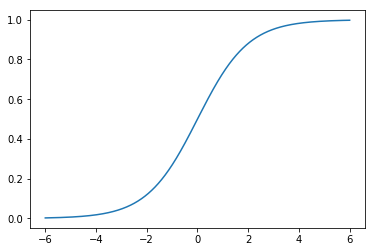

In [7]:
%pylab inline
import matplotlib.pyplot as plt

x = T.dvector('x')
s = 1 / (1 + T.exp(-x))
logistic = function([x], s)

# Build a numpy vector for the support of the function
x_eval = np.linspace(-6,6,1000)

# Evaluate the function. Note that Thenao understands numpy arrays.
y = logistic(x_eval)

# Plot
plt.plot(x_eval,y)

### Shared variables
Shared variables are hybrid symbolic and non-symbolic variables whose value may be shared between multiple functions. They are symbolic because they can be used just as the elements returned by `dvectors` or `dmatrices`, but they also adopt an internal value that defines the value the symbolci variable will have in all functions that share it. As we will see, shared values are useful when performing training in supervised learning algorithms, because we want these values to remain around across many executions of a Theano training or testing function. Often, the purpose of a Theano training function is to update the weights stored in a shared variable. And a testing function needs the current weights to perform the network's forward pass. A good example of how to use shared variables is by building an accumulator function:

In [7]:
from theano import shared

# We create a shared valuable and initiazlize it with value 0.
state = shared(0)

# Define a scalar variable with the increment
inc = T.iscalar('inc')

# Everytime the function is executed, our shared valuable is updated and returns old value
accumulator = function([inc], state, updates=[(state, state+inc)])

In [8]:
# Let us run it:
print(state.get_value())
accumulator(1)
# get_value extracts the current value of the shared variable.
# you can also reset this value with set_value

0


array(0)

In [9]:
print(state.get_value())
accumulator(300)

1


array(1)

In [10]:
print(state.get_value())
accumulator(300)

301


array(301)

## Differentiation in Theano
One reason why Theano is so powerful is because it uses Automatic Differentiation (autdiff) in order to compute gradients. Autdiff is a set of techniques to numerically evaluate the derivative of a function defined by a computer program. This implies that Theano can compute the derivative of any function for which you can write code (not only for parametric functions, but also data strcutures). Autdiff is different from numerical differentiation (which uses finite differences) and also from symbolic differentiation (which is a way to write new computer expressions for the derivative of a given function). Both numerical and symbolic differentiation can be very inefficient when calculating partial derivatives with respect to many inputs. Autdiffs solves for these problems.

At the core of autdiff is the concept of dual numbers. We can extend any natural number to a dual number:

$$x \rightarrow x + \epsilon x'$$

$\epsilon$ is just a symbol that distinguishes the second component, and we define its arithmetic as: $\epsilon^2 = 0$. With this, it is easy to see that:

$$(x + \epsilon x') + (y + \epsilon y') = x + y + \epsilon(x' + y')$$
$$(x + \epsilon x')(y + \epsilon y') = xy + \epsilon(xy' + x'y)$$
$$\frac{1}{x+\epsilon x'} = \frac{1}{x}-\epsilon\frac{x'}{x^2}$$

We can then apply these rules to a polinomial:

$$p(x) = p_0 + p_1x + p_2x^2 + ... + p_nx^n$$

to obtain:

$$
\begin{equation}
\begin{aligned}
p(x + \epsilon x') & = p_0 + p_1(x + \epsilon x' ) + ... + p_n(x + \epsilon x')^n \\
                   & = p_0 + p_1x + p_2x^2 + ... + p_nx^n \\
                   &   \, \, \, \, + \epsilon p_1x + 2\epsilon p_2 xx' + ... + n\epsilon p_nx^{n−1}x' \\
                   & = P(x) + \epsilon P'(x)x' \\
\end{aligned}
\end{equation}
$$

We are free to choose $x' = 1$ and then **a function applied to a dual number returns its derivative in the second dual component**. Dual numbers are data structures that allow us to carry the derivatives around without too much additional computation or errors. Theano profits from autdiff to compute complicated gradients in many dimensions using `T.grad`.

### Derivative of the logistic function
We can also compute the gradient of complex expressions such as the logistic function defined above. It turns out that the derivative of the logistic is: $ds(x)/dx = s(x) \cdot (1 - s(x))$. But we do not even need to know its symbolic expression to evaluate it at a given point:

In [10]:
# Create a Theno graph that computes the logistic function, 
# and plot the derivtaive for the range x in [-6,6]
x = T.dmatrix('x')
s = T.sum(1/(1+ T.exp(-x)))
gs = T.grad(s, x)

# create the callable function 
dlogistic = theano.function([x], gs)
dlogistic([[0,1],[-1,-2]])

array([[ 0.25      ,  0.19661193],
       [ 0.19661193,  0.10499359]])

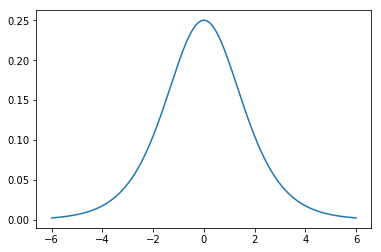

In [11]:
x = T.dvector('x')
s = T.sum(1/(1+ T.exp(-x)))
gs = T.grad(s, x)
dlogistic = theano.function([x], gs)
x_eval = np.linspace(-6,6, 1000)
y = dlogistic(x_eval)
plt.plot(x_eval, y)

## Gradient descent
Some parts of this section were taken from Sebastian Ruder's excellent blog on GD.

As we have seen, the key aspect of training a neural network has to do with minimizing a cost function $J(\theta)$. Gradient descent is a method that allows to do exactly that in a very effective way by updating the parameters $\theta$ in the opposite direction of the gradient of the objective function $\nabla_{\theta}J(\theta)$ w.r.t. to the parameters. In other words, you try to go down the slope in the direction where the slope is steeper. The learning rate $\eta$ determines the size of the steps we take to reach a (local) minimum. In other words, we follow the direction of the slope of the surface created by the objective function downhill until we reach a valley.

![](images/GD1.png){:height=300 width=300}![](images/GD2.png){:height=300 width=300}


The idea is that the direction we should pick to go down the slope to maximize the change in $J(\theta)$ is that of the gradient $\nabla_{\theta}J(\theta)$. This can be easily proved if we calculate the difference in $J$ for two different epochs: $\Delta J = J(\theta(t+1) - J(\theta(t)))$ (try it!) 

### Batch gradient descent

Vanilla gradient descent, aka batch gradient descent, computes the gradient of the cost function w.r.t. to the parameters $\theta$ for the entire training dataset:

$$\theta = \theta−\eta\nabla_{\theta}J(\theta;x;y)$$

Keep in mind that the cost function $J$ is the product of the individual likelihoods for each example in the training set, and so in order to produce one single update to the parameters, you need to use the entire training set.

## Classifying the Iris data set

The Iris flower data set is a multivariate data set introduced by Ronald Fisher in his 1936 to describ morphological properties of three related species of the Iris flower. The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres.

The goal of this part of the lab is to perform classification of this dataset using the logistic regression, and batch gradient descent to perform the minimization of the cost function (training).

In [12]:
%pylab inline

import matplotlib.pyplot as plt
import six.moves.cPickle as pickle
#import gzip
#import os
#import sys
import timeit

import numpy as np

import theano
import theano.tensor as T
#import matplotlib.pyplot as plt
#import csv
#import pandas as pd
import six.moves.cPickle as pickle

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/python3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['logistic']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [13]:
#iris_dataset = pd.read_csv('iris.csv')

In [13]:
#feats = []
#species = []
#for i in arange(len(iris_dataset['Sepal.Length'])):
#    feats.append(np.array([iris_dataset['Sepal.Length'][i],iris_dataset['Sepal.Width'][i],\
#                 iris_dataset['Petal.Length'][i],iris_dataset['Petal.Width'][i]]))
#    species.append(iris_dataset['Species'][i])

In [15]:
#iris_data = {'features': feats, 'species': species}

In [16]:
# pickle_file = open("iris_dataset.pickle", "wb")
# pickle.dump(iris_data, pickle_file)
# pickle_file.close()

### Load the dataset

The dataset is saved as a pickle file, and you can easily separate it into features and classes:

In [28]:
pkl_file = open('./iris_dataset.pickle', 'rb')
iris_data = pickle.load(pkl_file)
features = iris_data['features']
features = np.array(features)
species = iris_data['species']
species = np.array(species)

Let us explore the dataset a bit by plotting the features color-coded according to their class.

In [23]:
uni = np.unique(species)

species[species == uni[0]] = 0
species[species == uni[1]] = 1
species[species == uni[2]] = 2
species = species.astype(np.int)
print(species)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [25]:
# Shuffle entries and separate into training, validation and test sets:

indices = np.arange(150)
np.random.shuffle(indices)

species = species[indices]
features = features[indices]

train_set = [features[0:110],species[0:110]] #110
valid_set = [features[110:130],species[110:130]] #20
test_set = [features[130:150],species[130:150]] #20

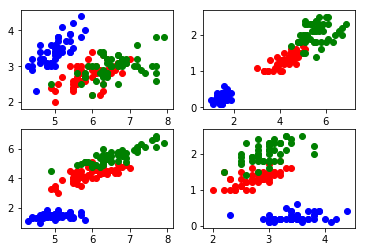

In [26]:
# Let us plot some of the features agains each other for different species

f, axarr = plt.subplots(2, 2)
axarr[0, 0].scatter(features[:,0][species == 0],features[:,1][species == 0],color = 'blue')
axarr[0, 0].scatter(features[:,0][species == 1],features[:,1][species == 1],color = 'red')
axarr[0, 0].scatter(features[:,0][species == 2],features[:,1][species == 2],color = 'green')
#axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(features[:,2][species == 0],features[:,3][species == 0],color = 'blue')
axarr[0, 1].scatter(features[:,2][species == 1],features[:,3][species == 1],color = 'red')
axarr[0, 1].scatter(features[:,2][species == 2],features[:,3][species == 2],color = 'green')
#axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].scatter(features[:,0][species == 0],features[:,2][species == 0],color = 'blue')
axarr[1, 0].scatter(features[:,0][species == 1],features[:,2][species == 1],color = 'red')
axarr[1, 0].scatter(features[:,0][species == 2],features[:,2][species == 2],color = 'green')
#axarr[0, 1].set_title('Axis [1,1]')
axarr[1, 1].scatter(features[:,1][species == 0],features[:,3][species == 0],color = 'blue')
axarr[1, 1].scatter(features[:,1][species == 1],features[:,3][species == 1],color = 'red')
axarr[1, 1].scatter(features[:,1][species == 2],features[:,3][species == 2],color = 'green')
#axarr[1, 1].set_title('Axis [1,1]')

## Using Theano to do classification with the logistic regression

We will use Theano to train a logistic regression classifier using this dataset. We leave validation and testing for the homework, but this part of the lab should form the basis of the code for your homework.
First, let us define symbolic variables for the features and the classes.

In [30]:
# Declare Theano symbolic variables for the features and the classes
x = T.dmatrix('x') # vector of features 
y = T.lvector('y') # vector of outputs

We create shared variables that contain the matrix of weights and the bias terms and initialize it with normally distributed values:

In [34]:
# initialize the weight vector w randomly

# this and the following bias variable b
# are shared so they keep their values
# between training iterations (updates)
w = theano.shared(np.random.randn(len(features[0]),len(np.unique(species))), name='w', borrow=True)

# w dimensions nfeatures x numclasses  for the softmax formulation each theta is the probability of each of the classes

In [35]:
# initialize the bias term
b = theano.shared(value=np.zeros((len(np.unique(species)),)), dtype=theano.config.floatX, name='b', borrow=True)

TypeError: No suitable SharedVariable constructor could be found. Are you sure all kwargs are supported? We do not support the parameter dtype or type. value="[ 0.  0.  0.]". parameters="{'dtype': 'float64', 'borrow': True}"

In [17]:
print("Initial model:")
print(w.get_value())
print(b.get_value())

Next step is the creation of the computational graph that computes the cost function for using all examples in the dataset. The likelihood is is built using the softmax formulation. In this formulation, we project the input vector into a set of hyperplanes that represent the different classes, and the distance from the vector to each of these hyperplanes relates to the probability of the input belonging to a given class. Write a graph that calculates the likelihood, the loss and the cost function, as well as the gradients of the cost function with respects to the weights and the bias terms. Use an L2 regularization approach.

In [613]:
# Construct Theano expression graph
p_y_given_x =                                   # Probability that target belongs to class i (softmax)
prediction =                                    # The prediction of the model (class whose probability is maximal)
loss =                                          # Loss function
cost =                                          # The cost to minimize with regularization
gw = 
gb =                                            # Compute the gradient of the cost
                                                # w.r.t weight vector w and
                                                # bias term b
                                                # (we shall return to this in a
                                                # following section of this tutorial)

Now write a Theano function that uses the graph to evaluate the predictions of the classiffier and the loss function for a single epoch, and evaluates the gradient using all examples of the training set in order to update the parameters (batch gradient descent). Leave the learning rate as an adjustable parameter.

In [614]:
# Compile. What is a good learning rate?
eta = 0.1 # Learning rate
train = theano.function(
          inputs=[x,y],
          outputs=[prediction, loss],
          updates=((w, w - eta * gw), (b, b - eta * gb)),name='train')
validate = 

test = 

predict = theano.function(inputs=[x], outputs=prediction, name='predict')

Now train your classifier using a certain number of epochs. Plot the evolution of the loss function for different values of the learning rate and the regularization parameter.

In [615]:
n_epochs = 50000

In [616]:
# Train and every certain number of empochs (let us say 500), evaluate
# the performance of the classifier on the validation set. Save the
# validation loss each time you do so.
errors = []
errors_val = []
for i in range(n_epochs):
    pred, err =                      # train function applied to the training set
    errors.append(err)
    
    if (i%500 == 0):
        pred_val, err_val =          # validate function applied to the validation set
        errors_val.append(err_val)

In [20]:
# Plot the validation losss
plt.plot(500*arange(len(errors_val)),np.array(errors_val),marker='o')
plt.yscale('log')
plt.axis('tight')

Now estimate the number of errors made by the classifier on the training set itself.

In [18]:
print("Final model:")
print(w.get_value())
print(b.get_value())
print("target values for D:")
print(test_set[1])
print("prediction on D:")
print(predict(test_set[0]))

In [619]:
# Estimate error
# Function to count errors
aa = T.dvector('aa')
bb = T.dvector('bb')
cc = T.mean(T.neq(aa, bb))
f_err = function([aa, bb], cc)

In [19]:
print('Test error = ',100.*f_err(test_set[1],predict(test_set[0])))